# Data Modeling - BOGO offer type

This notebook uses the datasets cleaned from the Data Wrangling step to perform predictive data modeling. The goal is to predict whether a Reward program user would complete a BOGO offer. 

### Evaluation Metrics

For this type of classification model, we do not need to concern about **False Positives (Type 1 error)** (users we predict as responding yes to offer but actually would respond no) as it is okay to send offers to more people in a promotion, as the company has much to gain when users complete offers and make purchases. 

We would, however, want to minimize **False Negatives (Type 2 error)** (users who are predicted as responding no to the offer but actually would complete the offers). We would definitely not want to exclude the offer from those who would complete it and make purchases as that would mean loss of sure revenue. 

In order to minimize False Negatives, we should select a model that has high Recall score, meaning that most of the yes responses are correctly recognized (low False Negatives) but there might be a lot of false Yes responses.

### Import data and libraries

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV

# Import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_precision_recall_curve, precision_recall_curve, average_precision_score

In [38]:
# read in the csv files
offer_response = pd.read_csv('data/offer_response.csv')
user = pd.read_csv('data/profile_cleaned.csv')

In [39]:
# Merge profile and number of offers completed
df = pd.merge(offer_response, 
             user, 
             how='left', 
             on=['person']).dropna().replace({True:1,False:0}).drop(columns=['person'])

In [40]:
bogo = df[df.offer_type=='bogo']

In [41]:
# Convert categorical variables into dummy variables
clean_bogo = pd.get_dummies(bogo, columns=['gender']).drop_duplicates().drop(columns=['offer_type'])

In [42]:
# Split features and dependent variable into training and test sets
y = clean_bogo['completed_offer']
X = clean_bogo.drop(['completed_offer'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 9092 samples.
Testing set has 2273 samples.


In [43]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [78]:
# Print evaluation metrics for a model (source: Udacity)
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (numpy array or pandas series)
    preds - the predictions for those values from some model (numpy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy, precision, recall, and F1 score
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
        print('Precision score: ', format(precision_score(y_true, preds)))
        print('Recall score: ', format(recall_score(y_true, preds)))
        print('F1 score: ', format(fbeta_score(y_true, preds, beta=1)))
        print('\n\n')
    
    else:
        print('Accuracy score for ' + model_name + ' :' , format(accuracy_score(y_true, preds)))
        print('Precision score ' + model_name + ' :', format(precision_score(y_true, preds)))
        print('Recall score ' + model_name + ' :', format(recall_score(y_true, preds)))
        print('F1 score ' + model_name + ' :', format(fbeta_score(y_true, preds,beta=1)))
        print('\n\n')

### Base Model: Logistic Regression

Accuracy score for Logistics Regression : 0.6832380114386274
Precision score Logistics Regression : 0.6984126984126984
Recall score Logistics Regression : 0.7814671814671814
F1 score Logistics Regression : 0.7376093294460642



Confusion matrix, without normalization
[[ 541  437]
 [ 283 1012]]
Normalized confusion matrix
[[0.55 0.45]
 [0.22 0.78]]


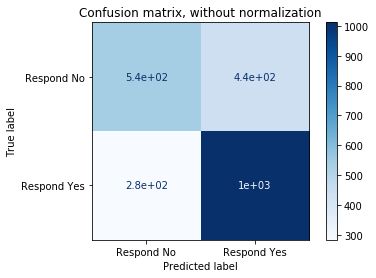

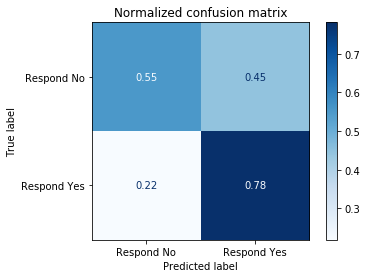

In [123]:
log_reg = LogisticRegression(C=59, penalty='l2')
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)

# Print the scores
print_metrics(y_test, y_pred,'Logistics Regression')

class_names = ['Respond No', 'Respond Yes']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(log_reg, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The Logistic Model has a higher Recall than Precision, which is what we would want in our final model. The Recall score for the model is 0.78, and we'll use this score to compare this model to the next models.

### SVM Model

In [81]:
# Initiate and fit SVC model
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Accuracy score for SVC : 0.6959964804223493
Precision score SVC : 0.6885143570536829
Recall score SVC : 0.8517374517374517
F1 score SVC : 0.7614773904038661




Confusion matrix, without normalization
[[ 479  499]
 [ 192 1103]]
Normalized confusion matrix
[[0.49 0.51]
 [0.15 0.85]]


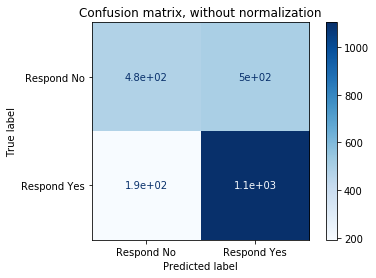

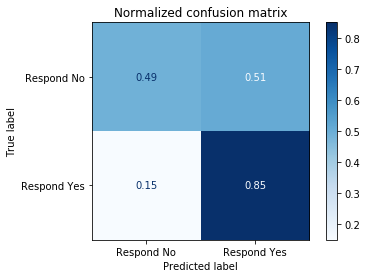

In [82]:
y_pred = svc.predict(X_test)

# Print the scores
print_metrics(y_test,y_pred,'SVC')
print()

class_names = ['Respond No', 'Respond Yes']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

SVC Model has a much higher Recall score (0.85) than the Logistic Regression model's (0.78). Since we're optimizing for high Recall score, this means that SVC model would be a better option than Logistic Regression model.

### Ensemble Models

In [117]:
# Initiate ensemble models
rf_mod = RandomForestClassifier()
ada_mod = AdaBoostClassifier()
gb_mod = GradientBoostingClassifier()

In [118]:
# Fit models
rf_mod.fit(X_train, y_train)
ada_mod.fit(X_train, y_train)
gb_mod.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [119]:
# Predict responses
rf_y_pred = rf_mod.predict(X_test)
ada_y_pred = ada_mod.predict(X_test)
gb_y_pred = gb_mod.predict(X_test)

In [120]:
# Print the scores
print_metrics(y_test, rf_y_pred, 'Random Forest')
print_metrics(y_test, ada_y_pred, 'AdaBoost')
print_metrics(y_test, gb_y_pred, 'Gradien Boost')

Accuracy score for Random Forest : 0.546854377474703
Precision score Random Forest : 0.5928521373510862
Recall score Random Forest : 0.6532818532818533
F1 score Random Forest : 0.6216017634092579



Accuracy score for AdaBoost : 0.6920369555653322
Precision score AdaBoost : 0.6837554045707227
Recall score AdaBoost : 0.8548262548262548
F1 score AdaBoost : 0.759780370624571



Accuracy score for Gradien Boost : 0.6858776946766388
Precision score Gradien Boost : 0.6830497794580971
Recall score Gradien Boost : 0.8370656370656371
F1 score Gradien Boost : 0.7522553782095766





### Model Comparison

Among all models we're built for this dataset, AdaBoost model gives us the highest F1-score along with SVC (F-beta score is takes both precision and recall into consideration). Besides Random Forest Classifier, most of the models selected perform equally well. 

|           | Logistic Regression | SVC  | Random Forest | AdaBoost | Gradient Boost |
|-----------|---------------------|------|---------------|----------|----------------|
| Accuracy  | 0.68                | 0.70 | 0.55          | 0.69     | 0.69           |
| Precision | 0.70                | 0.69 | 0.59          | 0.68     | 0.68           |
| Recall    | 0.78                | 0.85 | 0.66          | 0.85     | 0.84           |
| F1        | 0.74                | 0.76 | 0.62          | 0.76     | 0.75           |

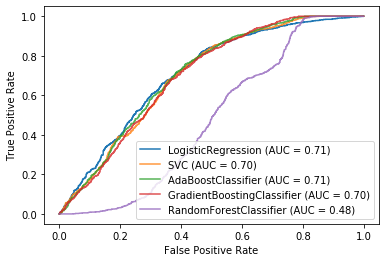

In [121]:
# Plot ROC curve
log_disp = plot_roc_curve(log_reg, X_test, y_test)
ax = plt.gca()
svc_disp = plot_roc_curve(svc, X_test, y_test, ax=ax, alpha=0.8)
ada_disp = plot_roc_curve(ada_mod, X_test, y_test, ax=ax, alpha=0.8)
gb_disp = plot_roc_curve(gb_mod, X_test, y_test, ax=ax, alpha=0.8)
rf_disp = plot_roc_curve(rf_mod, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

### Hyper-parameter tuning for SVC and AdaBoost

#### Tune SVC

In [112]:
# Set the parameters by cross-validation
tuned_parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

print("# Tuning hyper-parameters for recall score")
print()

clf = GridSearchCV(
    SVC(), tuned_parameters, scoring='recall_macro')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print_metrics(y_true, y_pred)
print()

# Tuning hyper-parameters for recall score

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.606 (+/-0.012) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.668 (+/-0.017) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.670 (+/-0.012) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.613 (+/-0.015) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.623 (+/-0.014) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.668 (+/-0.013) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.673 (+/-0.015) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.670 (+/-0.012) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.616 (+/-0.016) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.522 (+/-0.018) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.662 (+/-0.022) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.673 (+/-0.012) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.672 (+/-0.013) 

In [113]:
tuned_svc = SVC(C=1000,gamma=0.001,kernel='rbf',random_state=42)
tuned_svc.fit(X_train, y_train)
tuned_svc_y_pred = tuned_ada.predict(X_test)
print_metrics(y_test, tuned_svc_y_pred, 'Optimized SVC')

Accuracy score for Optimized SVC : 0.6946766388033436
Precision score Optimized SVC : 0.6840171463563993
Recall score Optimized SVC : 0.8625482625482626
F1 score Optimized SVC : 0.7629781420765028





#### Tune AdaBoost

In [103]:
# Set the parameters by cross-validation
tuned_parameters = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'algorithm' : ['SAMME', 'SAMME.R']
 }

print("# Tuning hyper-parameters for recall score")
print()

print(AdaBoostClassifier().get_params().keys())

clf = GridSearchCV(
    AdaBoostClassifier(), tuned_parameters, scoring='recall_macro')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print_metrics(y_true, y_pred)
print()

# Tuning hyper-parameters for recall score

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])
Best parameters set found on development set:

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}

Grid scores on development set:

0.651 (+/-0.022) for {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 50}
0.607 (+/-0.041) for {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 100}
0.599 (+/-0.014) for {'algorithm': 'SAMME', 'learning_rate': 0.05, 'n_estimators': 50}
0.599 (+/-0.014) for {'algorithm': 'SAMME', 'learning_rate': 0.05, 'n_estimators': 100}
0.599 (+/-0.014) for {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
0.636 (+/-0.040) for {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
0.662 (+/-0.024) for {'algorithm': 'SAMME', 'learning_rate': 0.3, 'n_estimators': 50}
0.661 (+/-0.022) for {'algorithm': 'SAMME', 'learning_rate': 0.3, 'n_estimators': 100}
0.662 (+/-0.024) fo

In [110]:
tuned_ada = AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.1,n_estimators=100,random_state=42)
tuned_ada.fit(X_train, y_train)
tuned_ada_y_pred = tuned_ada.predict(X_test)
print_metrics(y_test, tuned_ada_y_pred, 'Optimized AdaBoost')

Accuracy score for Optimized AdaBoost : 0.6946766388033436
Precision score Optimized AdaBoost : 0.6840171463563993
Recall score Optimized AdaBoost : 0.8625482625482626
F1 score Optimized AdaBoost : 0.7629781420765028





**Compare the tuned models**

|           | Tuned SVC | Tuned AdaBoost |
|-----------|-----------|----------------|
| Accuracy  | 0.69      | 0.69           |
| Precision | 0.68      | 0.68           |
| Recall    | 0.86      | 0.86           |
| F1        | 0.76      | 0.76           |

#### Plot ROC curves

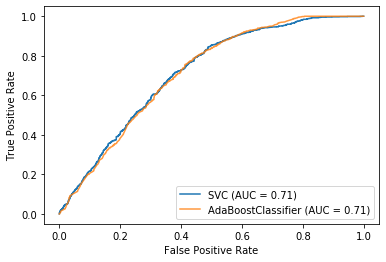

In [115]:
tuned_svc_disp = plot_roc_curve(tuned_svc, X_test, y_test)
ax = plt.gca()
tuned_ada_disp = plot_roc_curve(tuned_ada, X_test, y_test,ax=ax, alpha=0.8)
plt.show()